# Data Exploration 

In [1]:
#Imports
import pandas as pd
import numpy as np
import datetime
import os
import warnings
import json


import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

import tsfresh
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Connect to database 

In [2]:
# Load the file 
json_data = json.loads(open('../../db_conn.json').read())

conn = 'mysql+pymysql://'+json_data["user"]+':'+json_data["password"]+'@'+json_data["host"]+':'+str(json_data["port"])+'/'+json_data["db_name"]

In [3]:
# Connect to the DB
mysql_engine = create_engine(conn,echo=False)

## Explore the sales data

Get the sales data for each of the products at each store, each day in which the sales were above 0. 

In [4]:
sales_df = pd.read_sql_query("""select * from train where units>0""", conn)

In [19]:
sales_df.date = pd.to_datetime(sales_df.date)

In [20]:
sales_df.head()

,date,store_nbr,item_nbr,units
0,2012-01-01,1,9,29
1,2012-01-01,1,28,2
2,2012-01-01,1,51,1
3,2012-01-02,1,9,60
4,2012-01-02,1,28,5


In [21]:
#fig, ax = plt.subplots(1,1, figsize=(10,10))
store_sales = sales_df.groupby(['date','store_nbr']).sum().reset_index()[['date','store_nbr','units']]
store_sales.head()

,date,store_nbr,units
0,2012-01-01,1,32
1,2012-01-01,2,406
2,2012-01-01,3,326
3,2012-01-01,4,82
4,2012-01-01,5,41


### Sales behavior

In [22]:
sales_df['yearweek'] = sales_df.date.dt.strftime('%Y-%U')

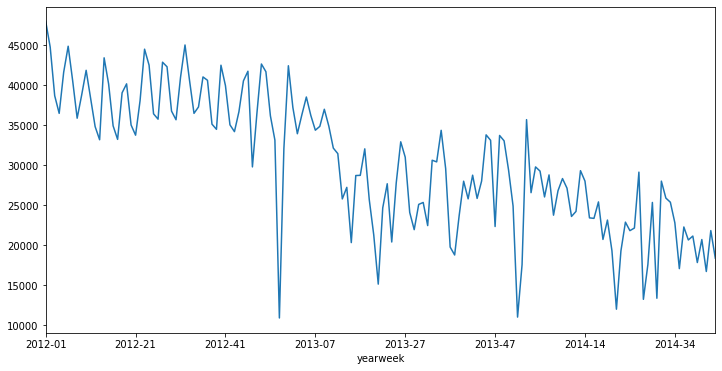

In [23]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
sales_df.groupby('yearweek').sum()['units'].plot(kind='line', ax=ax)

In general, we see that sales are going down over time, the company is not selling as many products as it used to. Furthermore, we see significant seasonality in these 111 products (as expected), hence, forecasting the behavior of these "weather-sensitive" products would be beneficial in terms operations and inventory. 

### Most active stores 

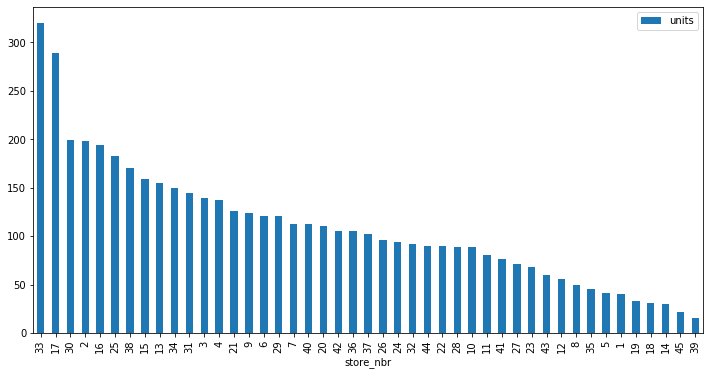

In [24]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
store_sales.groupby('store_nbr').mean().sort_values(by='units', ascending=False).plot(kind='bar', ax=ax)

Stores 33 and 17 sell the most by far, with around 300 items per day.

### Most important products

Now let's check the top items in terms of sales, since these will be the ones presenting difficulties in terms of supply chain and logistics. 

Text(0.5, 1.0, 'Daily average sales for top 50 items')

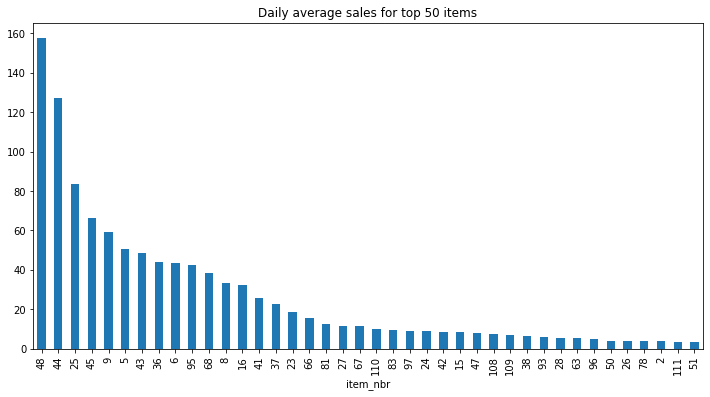

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
sales_df.groupby('item_nbr')['units'].mean().sort_values(ascending=False).iloc[0:40].plot(kind='bar', ax=ax)
ax.set_title('Daily average sales for top 50 items')

Now let's see the percentage each product represents in total items sold. 

In [26]:
# Get count of items sold
product_sales = sales_df.groupby('item_nbr')['units'].sum().sort_values(ascending=False)

In [27]:
# Get top 15
product_sales.divide(product_sales.sum())[0:3].sum()

0.6075027040834129

In [28]:
# Get count for top 3
product_sales[0:3]

item_nbr
45    1005111
9      916615
5      846662
Name: units, dtype: int64

So for this analysis, we have that about 92% of the sales are represented by the top 10 products in sales (out of 111), being products 45, 9 and 5 accountable for about 61% of the total items sold, which is over 2.7 M products sold. It's important here that these two products are 4th and 5th when it comes to daily average sales, which indicates that there might be some **seasonality** for these products. Let's look into it.

In [29]:
#Extract a subset of the sales for these 2 items
subset_sales = sales_df[sales_df.item_nbr.isin([45,9,5])].reset_index(drop=True)

In [30]:
subset_sales.head()

,date,store_nbr,item_nbr,units,yearweek
0,2012-01-01,1,9,29,2012-01
1,2012-01-02,1,9,60,2012-01
2,2012-01-03,1,9,15,2012-01
3,2012-01-04,1,9,20,2012-01
4,2012-01-05,1,9,16,2012-01


Let's review daily behavior first: 

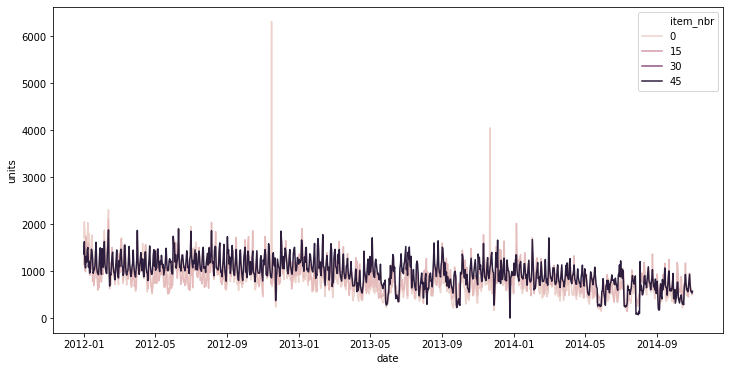

In [31]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
sns.lineplot(data=subset_sales.groupby(['date','item_nbr']).sum().reset_index(), x='date', y='units', hue='item_nbr')

It's difficult to interpret what's going on here, hence, let's try to go for a more aggregated way of looking at the data, for example by week. 

In [32]:
subset_sales['yearweek'] = subset_sales.date.dt.strftime("%Y-%U")

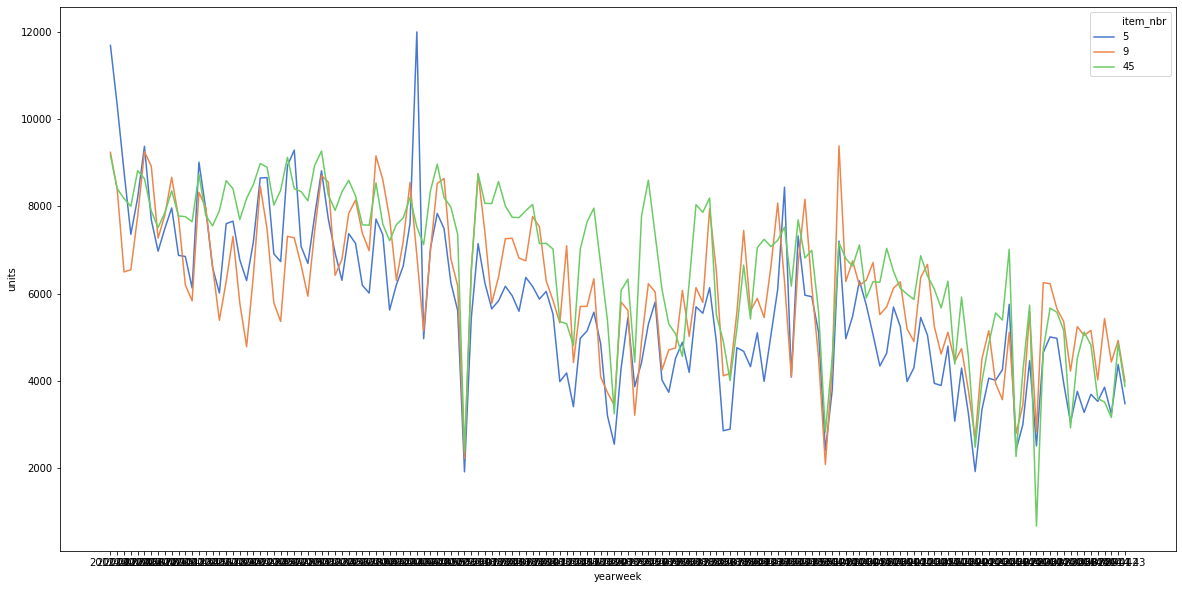

In [38]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
subset_sales_summary = subset_sales.groupby(['yearweek','item_nbr']).sum().reset_index()

colors = {45:'red', 9:'blue', 5:'green'}
sns.lineplot(x=subset_sales_summary['yearweek'], 
             y=subset_sales_summary['units'], 
             hue=subset_sales_summary['item_nbr'],
             palette=sns.color_palette("muted", 3),
             ax=ax)
#ax.set_xticklabels(labels, rotation=30)

We see a lot of variability in the demand for these products, specifically for number 9, its variability remains constant througout the whole dataset, on the other hand, the variability of product 45 demand increases significantly over time. These are definetly some products of interest when it comes to sales forecasting and stock provisioning.  

**We will use these 3 products, since they represent a significant percentage of the sales, it will be a major improvement for all stores if we can forecast its demand.** 

## Explore weather data 

In [5]:
#Get number of stores
stores_stations = pd.read_sql_query("""select * FROM RetailWeather.key ORDER BY store_nbr;""", conn)

In [6]:
stores_stations.store_nbr.nunique(), stores_stations.station_nbr.nunique()

(45, 20)

So we have 45 stores, each with one of the 20 weather stations (`station_nbr`) assigned to it, which has recorded the weather conditions for that specific station during 3 years. Now we are going to extract the weather data:

In [7]:
#Get number of stations
weather_df = pd.read_sql_query("""select * from weather;""", conn) 

In [8]:
weather_df.date = pd.to_datetime(weather_df.date)

In [9]:
weather_df.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaT,NaT,RA FZFG BR,NaN,0.05,29.78,29.92,3.6,20.0,4.6
1,1,2012-01-02,50.0,31.0,41.0,NaN,26.0,35.0,24.0,0.0,NaT,NaT,,NaN,0.01,29.44,29.62,9.8,24.0,10.3
2,1,2012-01-03,32.0,11.0,22.0,NaN,4.0,18.0,43.0,0.0,NaT,NaT,,NaN,0.00,29.67,29.87,10.8,31.0,11.6
3,1,2012-01-04,28.0,9.0,19.0,NaN,-1.0,14.0,46.0,0.0,NaT,NaT,,NaN,0.00,29.86,30.03,6.3,27.0,8.3
4,1,2012-01-05,38.0,25.0,32.0,NaN,13.0,25.0,33.0,0.0,NaT,NaT,,NaN,0.00,29.67,29.84,6.9,25.0,7.8


Check if all stations are inside our `stores_stations` data. 

In [10]:
weather_df.station_nbr.unique() in stores_stations.station_nbr.unique()

True

Now that we have the weather conditions for every station, let's take a look at how the weather changes accross the city. 

In [11]:
weather_df.shape

(20517, 20)

Let's analyze this data by month or week across all stations. 

In [12]:
#Add a year-month variable and year-week
weather_df['yearweek'] = weather_df.date.dt.strftime('%Y-%U')
weather_df['yearmonth'] =weather_df.date.dt.strftime('%Y-%m')

Check continuity for all stations to review similarities/differences between stations 

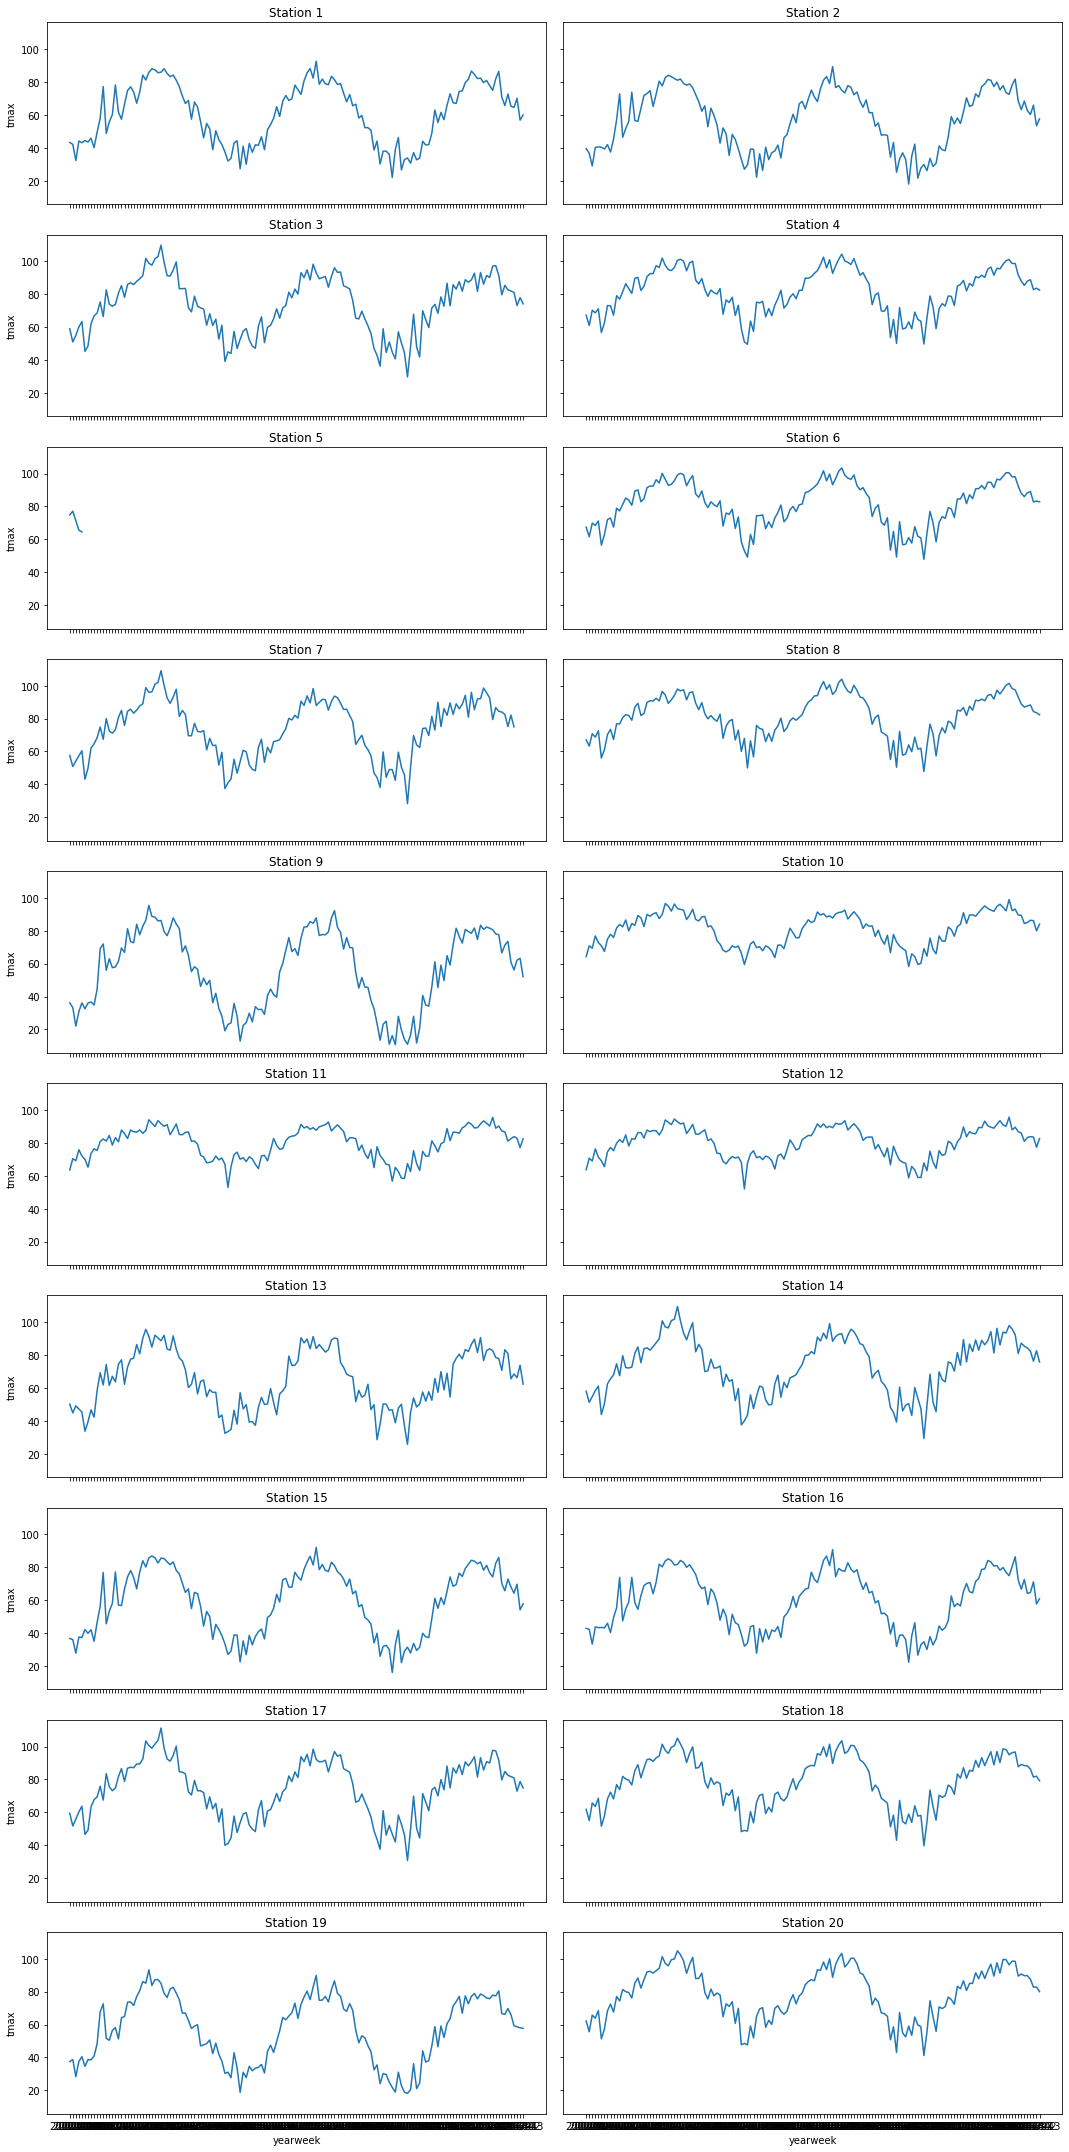

In [14]:
fig, axes = plt.subplots(10,2, figsize=(15,30), sharex=True, sharey=True)

tavg_by_stat = weather_df.groupby(['yearweek', 'station_nbr'])[['tmax']].mean().reset_index()

for ax, station in zip(axes.flat, weather_df.station_nbr.unique()):
    sns.lineplot(data=tavg_by_stat.loc[tavg_by_stat.station_nbr == station], x='yearweek', y='tmax', ax=ax)
    ax.set_title(f'Station {station}')

fig.tight_layout()

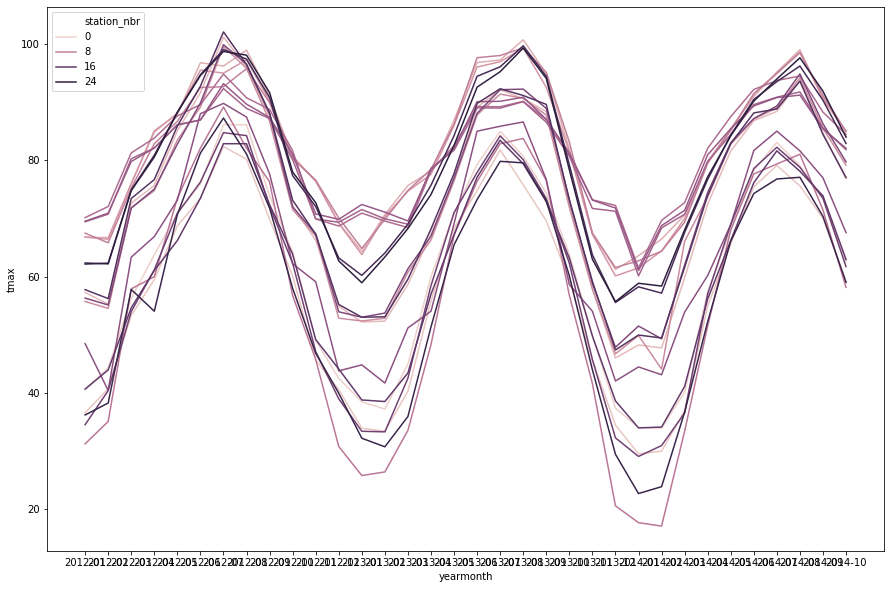

In [15]:
tavg_by_stat = weather_df.groupby(['yearmonth', 'station_nbr'])[['tmax']].mean().reset_index()

fig,ax = plt.subplots(1,1, figsize=(15,10))
sns.lineplot(data=tavg_by_stat, x='yearmonth', y='tmax', hue='station_nbr', ax=ax)
#ax.set_xticklabels()

Some observations from these plots:

* We have significant null values in every station, we will have to work on those later.
* Station 5 and station 8 (and all stores related to these) will be ommited from the analysis since they are incomplete and mostly null.
* We can see that the behavior across stations is not constant at all, not even at a large scale, hence, we will will not be able to aggregate the data in order to generate predictions.
* In the second plot, we see the monthly behavior of the temperature across all stations, we can see here that temperatures tend to group in 2 to 3 clusters with similar behavior, indicating that the readings from these stations are similar and might be in the same area (or city). 

## Grouping different stations (stores) by weathers 

Since we know that all stores have one station associated to it, and we also know that some stations are similar in terms of its weather characteristics, we might generalize models for these three clusters of stations and stores in order to obtain a model suited for each kind of weather. 

### `tsfresh` time-series feature extraction  

In order to compare the different time series, we are going to use `tsfresh` This package allows us to extract relevant features of each of the time series from over 1200 features extracted, which the can be used for clustering time series with similar characteristics. 

Let's filter out stations 5 and 8 given data incompleteness previously reviewed. 

In [64]:
weather_df = weather_df[~weather_df.station_nbr.isin([5,8])]

#### Data preprocessing 

First, let's take a look at the NAs for the entire dataset 

In [65]:
weather_df.isna().sum().sort_values(ascending=False)

depart         9654
sunrise        8590
sunset         8590
snowfall       5372
wetbulb         336
sealevel        242
heat            179
cool            179
tavg            179
dewpoint        170
resultspeed     111
resultdir       111
tmin             74
tmax             70
stnpressure      67
avgspeed         48
preciptotal      33
date              0
yearmonth         0
yearweek          0
codesum           0
station_nbr       0
dtype: int64

We see a significant amount of null values that we will have to deal with in the future, but first let's check correlation between variables. 

#### Studying correlation between weather variables 

Weather related variables are known to present significant correlation for different categories (Watanabe et al.), i.e. temperatures, precipitations, pressures, etc. Therefore, it's important to evaluate such correlations in order to clean our weather fields for feature extraction as much as possible. Let's take a look at how variables are correlated to each other:

[Text(0, 0, 'tmax'),
 Text(0, 0, 'tmin'),
 Text(0, 0, 'tavg'),
 Text(0, 0, 'depart'),
 Text(0, 0, 'dewpoint'),
 Text(0, 0, 'wetbulb'),
 Text(0, 0, 'heat'),
 Text(0, 0, 'cool'),
 Text(0, 0, 'snowfall'),
 Text(0, 0, 'preciptotal'),
 Text(0, 0, 'stnpressure'),
 Text(0, 0, 'sealevel'),
 Text(0, 0, 'resultspeed'),
 Text(0, 0, 'resultdir'),
 Text(0, 0, 'avgspeed')]

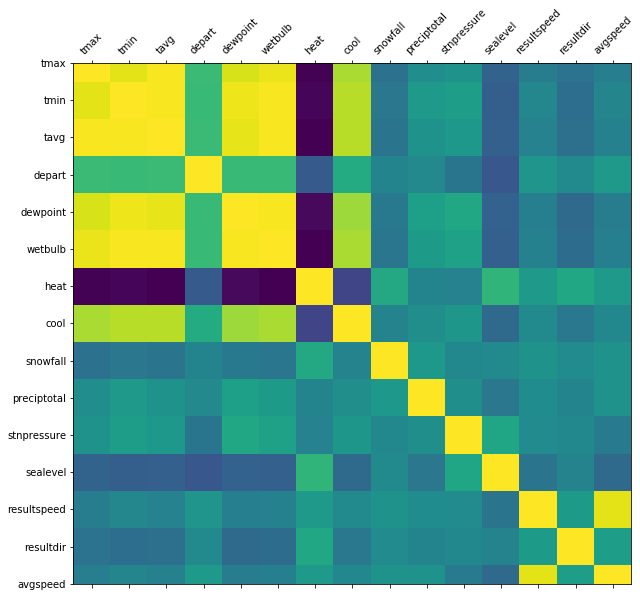

In [66]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

names = weather_df.columns[~weather_df.columns.isin(['date', 
                                                     'station_nbr',
                                                     'yearmonth',
                                                     'yearweek',
                                                    'codesum',
                                                    'sunrise',
                                                    'sunset'])]

ax.matshow(weather_df[names].corr(),
               interpolation='none')
#fig.colorbar(im)

ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=45)
ax.set_yticks(np.arange(len(names)))
ax.set_yticklabels(names)


Now, we can apply a PCA in order to check how these different features are related. 

In [67]:
# Subset our weather matrix according to required names
X = weather_df[names]
X = X.dropna(how='any')
X.shape

#Get correlation matrix
similarities = X.corr()

In [68]:
# Apply PCA
pca = PCA(n_components=2)


In [69]:
corr_pca = pca.fit_transform(similarities)
# Succeeds

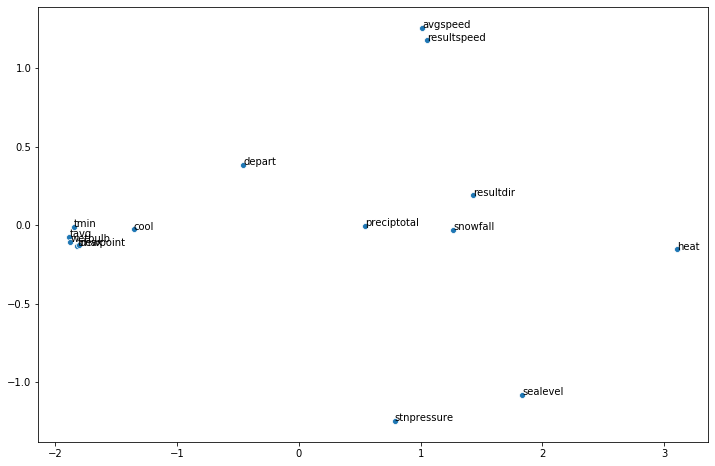

In [70]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.scatterplot(x=corr_pca[:,0], 
                y=corr_pca[:,1], ax=ax)

for i, txt in enumerate(X.columns):
    ax.annotate(txt, (corr_pca[i,0],
                      corr_pca[i,1]))

Considering this observation and other related factors like data sparseness, they selected following variables as the explanatory variables of the analysis:

* average atmospheric pressure at station (`stnpressure`)
* total precipitation (`preciptotal`)
* maximum temperature (`tmax`)
* average wind speed (`avgspeed`)

In [71]:
weather_feat = weather_df[['station_nbr', 'yearmonth', 'stnpressure', 'preciptotal', 'tmax', 'preciptotal']]
weather_feat = weather_feat.dropna(how='any')

In [72]:
weather_feat.station_nbr.nunique()

18

After we remove NAs, we end up with 18 stations that are active and have some data to be clusterd.

#### Applying ts feature extraction 

In [74]:
extracted_features = tsfresh.extract_features(weather_feat, column_id="station_nbr", column_sort="yearmonth")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 18/18 [03:38<00:00, 12.14s/it]


As shown in the documentation, these feature extraction process generates a significant number of NAs in the process. We will have to remove the features containing NAs for the clustering process. 

In [75]:
#Remove NAs
extracted_features = extracted_features.dropna(axis=1, how='any')

In [76]:
extracted_features.shape

(18, 2247)

So we end up with more than 2200 features for every station's time series that we can use to cluster. However, that might be too much, we will apply PCA to reduce dimensionality the number of features.

In [77]:
pca = PCA(n_components=18) #Max number of features
extracted_features_pca = pca.fit_transform(extracted_features)

In [78]:
extracted_features_pca.shape

(18, 18)

### Cluster the weather stations

We will now use those 18 features for each time series to cluster weather stations usnig KMeans

In [80]:
#Get feature matrix
X = extracted_features_pca

# Create vector for number of clusters 
no_clusters = np.linspace(2,10,9, dtype='int')

# Create instances of model and fit all models
km_models = [KMeans(n_clusters=no).fit(X) for no in no_clusters]

# Get scree plot to detect elbow
inertias = [model.inertia_ for model in km_models]

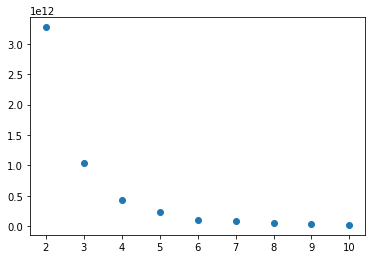

In [84]:
plt.scatter(x=no_clusters, y=inertias)

It seems like the optimal amount of clusters is between 3 and 4, let's extract the labels and confirm visually if the time series are clustered correctly when we pick 3

In [139]:
# Get model with 3 clusters
optimal_km = km_models[1]

In [140]:
labels = optimal_km.labels_

In [141]:
#Get cluster counts
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 7, 1: 7, 2: 4}

Create a map of labels for each of the `station_nbr` 

In [142]:
labels_map = {station: label for station, label in zip(extracted_features.index.unique(), labels)}

In [143]:
labels_map

{1: 1,
 2: 1,
 3: 2,
 4: 0,
 6: 0,
 7: 2,
 9: 1,
 10: 0,
 11: 0,
 12: 0,
 13: 1,
 14: 2,
 15: 1,
 16: 1,
 17: 2,
 18: 0,
 19: 1,
 20: 0}

Back to our plot from a previous section, we will plot the max temperature and the clusters with the same color.

In [144]:
tmax_by_stat = weather_df.groupby(['yearmonth', 'station_nbr'])[['tmax']].mean().reset_index()

In [145]:
# Add the cluster to which it belongs
tmax_by_stat['cluster'] = tmax_by_stat.station_nbr.apply(lambda x: labels_map[x])

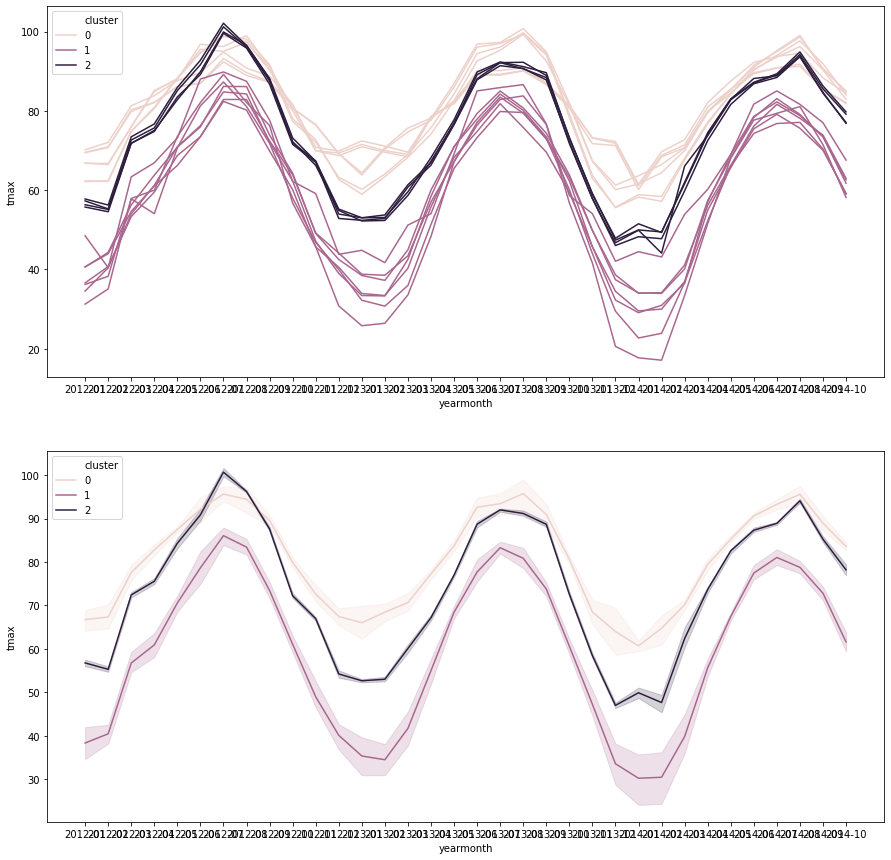

In [148]:
fig,ax = plt.subplots(2,1, figsize=(15,15))

# All series
sns.lineplot(data= tmax_by_stat, 
             x='yearmonth', 
             y='tmax',
             hue='cluster',
             units='station_nbr', 
             estimator=None,
             ax=ax[0])
# Means
sns.lineplot(data= tmax_by_stat, x='yearmonth', y='tmax', hue='cluster', ax=ax[1])

We then see three clusters of stations, which we will call "cities". We will use these cities, to cluster the activity at each of the stores so that we can **generalize the prediction model by cities** and it can be used by multiple stores and the data can be shared across stores of the same city.  

This `label_map` variable would be very useful to tag activities from all stores, we will save it to a file to load it later.

In [165]:
pd.DataFrame({'stores': list(labels_map.keys()),
             'cluster': list(labels_map.values())}).set_index('stores').to_csv('labels_map.csv')

### Future work: some other variables that could be used for the analysis 

* weather related variables
* quantity sold the previous day
* day of the week
* season
* price (check)
